In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Define paths
train_dir = 'data/train'
test_dir = 'data/test'

# Image dimensions
img_height, img_width = 100, 100

# Load training data
train_data = []
train_labels = []

emotions = ['angry', 'fear', 'happy', 'sad', 'surprise']

for emotion in emotions:
    emotion_dir = os.path.join(train_dir, emotion)
    for img_name in os.listdir(emotion_dir):
        img_path = os.path.join(emotion_dir, img_name)
        img = imread(img_path, as_gray=True)  # Load image as grayscale
        img_resized = resize(img, (img_height, img_width), anti_aliasing=True)
        train_data.append(img_resized)
        train_labels.append(emotion)

train_data = np.array(train_data)
train_labels = np.array(train_labels)

# Check the shape of the data
print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")


Training data shape: (9108, 100, 100)
Training labels shape: (9108,)


In [6]:
# Normalize image data to 0-1 range
train_data = train_data.reshape(-1, img_height, img_width, 1) / 255.0

# Encode labels
label_map = {emotion: i for i, emotion in enumerate(emotions)}
train_labels_encoded = np.array([label_map[label] for label in train_labels])
train_labels_categorical = to_categorical(train_labels_encoded)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels_categorical, test_size=0.2, random_state=42)

# Check the shape of the data after preprocessing
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")


X_train shape: (7286, 100, 100, 1)
y_train shape: (7286, 5)
X_val shape: (1822, 100, 100, 1)
y_val shape: (1822, 5)


In [7]:
from tensorflow.keras.optimizers import Adam

# Build a deeper CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(emotions), activation='softmax')
])

# Compile the model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 128)     

In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the model with data augmentation
batch_size = 32
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

history = model.fit(train_generator, epochs=30, validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // batch_size)


Epoch 1/30


2024-05-25 12:38:21.019986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 23s 101ms/step - loss: 1.5884 - accuracy: 0.2204 - val_loss: 1.5911 - val_accuracy: 0.2097
Epoch 2/30
227/227 [==============================] - 23s 103ms/step - loss: 1.5892 - accuracy: 0.2239 - val_loss: 1.5890 - val_accuracy: 0.2097
Epoch 3/30
227/227 [==============================] - 24s 105ms/step - loss: 1.5893 - accuracy: 0.2167 - val_loss: 1.5902 - val_accuracy: 0.2097
Epoch 4/30
 90/227 [==========>...................] - ETA: 14s - loss: 1.5911 - accuracy: 0.2233

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

In [ ]:
# Load and preprocess test data
test_data = []
test_ids = []

for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)
    img = plt.imread(img_path)
    test_data.append(img)
    test_ids.append(img_name)

test_data = np.array(test_data) / 255.0

# Predict test data
predictions = model.predict(test_data)
predicted_labels = [emotions[np.argmax(pred)] for pred in predictions]

# Create submission DataFrame
submission_df = pd.DataFrame({
    'Id': test_ids,
    'emotions': predicted_labels
})

# Save to CSV
submission_df.to_csv('submission.csv', index=False)

Epoch 1/50


2024-05-25 20:52:55.000981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


114/114 [==============================] - 31s 264ms/step - loss: 2.1254 - accuracy: 0.2731 - val_loss: 5.3394 - val_accuracy: 0.2102 - lr: 0.0010
Epoch 2/50
114/114 [==============================] - 31s 270ms/step - loss: 1.7364 - accuracy: 0.3254 - val_loss: 2.6490 - val_accuracy: 0.2256 - lr: 0.0010
Epoch 3/50
114/114 [==============================] - 31s 268ms/step - loss: 1.5568 - accuracy: 0.3851 - val_loss: 2.6799 - val_accuracy: 0.2267 - lr: 0.0010
Epoch 4/50
114/114 [==============================] - 32s 277ms/step - loss: 1.4355 - accuracy: 0.4204 - val_loss: 1.5416 - val_accuracy: 0.3897 - lr: 0.0010
Epoch 5/50
114/114 [==============================] - 31s 273ms/step - loss: 1.3330 - accuracy: 0.4634 - val_loss: 2.8340 - val_accuracy: 0.2574 - lr: 0.0010
Epoch 6/50
114/114 [==============================] - 33s 292ms/step - loss: 1.2681 - accuracy: 0.4876 - val_loss: 1.4211 - val_accuracy: 0.3672 - lr: 0.0010
Epoch 7/50
114/114 [==============================] - 32s 278ms

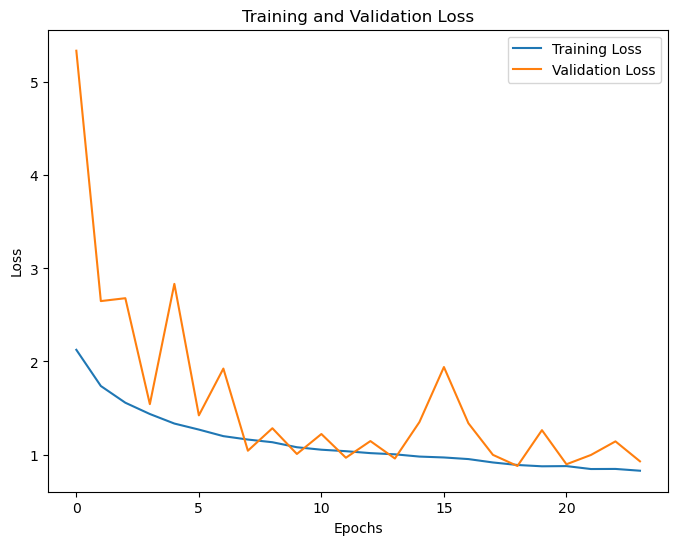

In [12]:
from matplotlib import pyplot as plt
import os
import numpy as np
import csv
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Load the data
train_dir = 'data/train'
emotions = os.listdir(train_dir)
X_train, y_train = [], []
for emotion in emotions:
    emotion_dir = os.path.join(train_dir, emotion)
    for img_file in os.listdir(emotion_dir):
        img_path = os.path.join(emotion_dir, img_file)
        img = load_img(img_path, target_size=(100, 100), color_mode='grayscale')
        img_array = img_to_array(img) / 255.0
        X_train.append(img_array)
        y_train.append(emotions.index(emotion))

X_train = np.array(X_train)
y_train = to_categorical(y_train, num_classes=len(emotions))

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reshape the data for CNN input
X_train = X_train.reshape(X_train.shape[0], 100, 100, 1)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 1)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Build the enhanced model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(emotions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    validation_data=(X_val, y_val),
                    epochs=50,
                    callbacks=[early_stop, reduce_lr])

print("Model trained successfully")

# Make predictions on the test set
test_dir = 'data/test'
X_test = []
test_filenames = []
for img_file in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_file)
    img = load_img(img_path, target_size=(100, 100), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0
    X_test.append(img_array)
    test_filenames.append(img_file)

X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], 100, 100, 1)
y_pred = model.predict(X_test)
predicted_labels = [emotions[np.argmax(prob)] for prob in y_pred]

# Store predictions in a CSV file
with open('submission.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Id', 'emotions'])
    for filename, label in zip(test_filenames, predicted_labels):
        writer.writerow([filename, label])

print("Predictions saved to submission.csv")

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
